In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import quad
from scipy.optimize import fsolve

## System equations

In [2]:
def system_dynamics(U, w1, w2, w3, Q, I1, I2, F_max, x_0, k, tau):
    U1, U2 = U
    eq1 = (-U1 + logistic(w1*U1 + I1 - Q*w2*U2 - (1 - Q)*w3*logistic(U1 + U2, F_max, x_0, k), F_max, x_0, k)) / tau
    eq2 = (-U2 + logistic(w1*U2 + I2 - Q*w2*U1 - (1 - Q)*w3*logistic(U1 + U2, F_max, x_0, k), F_max, x_0, k)) / tau
    return [eq1, eq2]


def logistic(U, F_max, x_0, k):
    exponent = -k * (U - x_0)
    with np.errstate(over='ignore'):
        exp_term = np.exp(exponent) if exponent > -700 else 0.0   # Threshold to prevent overflow
    return F_max / (1 + exp_term)


def dlogistic(U, f_max, x_0, k):
    exp_term = np.exp(-k * (U - x_0))
    return (k * f_max * exp_term) / ((1 + exp_term)**2)


def jacobian(U1, U2, w1, w2, w3, Q, I1, I2, F_max, x_0, k, tau):
    H1 = w1 * U1 + I1 - Q * w2 * U2 - (1 - Q) * w3 * logistic(U1 + U2, F_max, x_0, k)
    H2 = w1 * U2 + I2 - Q * w2 * U1 - (1 - Q) * w3 * logistic(U1 + U2, F_max, x_0, k)
    H3 = U1 + U2

    df_H1 = dlogistic(H1, F_max, x_0, k)
    df_H2 = dlogistic(H2, F_max, x_0, k)
    df_H3 = dlogistic(H3, F_max, x_0, k)

    J11 = (-1 + df_H1 * (w1 - (1 - Q) * w3 * df_H3)) / tau
    J12 = (-df_H1 * (Q * w2 - (1 - Q) * w3 * df_H3)) / tau
    J21 = (-df_H2 * (Q * w2 - (1 - Q) * w3 * df_H3)) / tau
    J22 = (-1 + df_H2 * (w1 - (1 - Q) * w3 * df_H3)) / tau

    J = np.array([[J11, J12],
                  [J21, J22]])
    return J

#### Compute the Jacobian with sympy

In [3]:
from sympy import symbols, diff, Function, Matrix, exp

# Define symbolic variables
U1, U2, w1, w2, w3, Q, I1, I2, F_max, x_0, k, tau = symbols('U1 U2 w1 w2 w3 Q I1 I2 F_max x_0 k tau')
U = Matrix([U1, U2])

# Define the logistic function symbolically
def logistic_sym(U, F_max, x_0, k):
    return F_max / (1 + exp(-k * (U - x_0)))

# Define the system of equations
eq1 = (-U1 + logistic_sym(w1*U1 + I1 - Q*w2*U2 - (1 - Q)*w3*logistic_sym(U1 + U2, F_max, x_0, k), F_max, x_0, k)) / tau
eq2 = (-U2 + logistic_sym(w1*U2 + I2 - Q*w2*U1 - (1 - Q)*w3*logistic_sym(U1 + U2, F_max, x_0, k), F_max, x_0, k)) / tau
system_eqns = Matrix([eq1, eq2])

# Calculate the Jacobian matrix
jacobian_matrix = system_eqns.jacobian(U)
jacobian_matrix

Matrix([
[(F_max*k*(-F_max*k*w3*(1 - Q)*exp(-k*(U1 + U2 - x_0))/(1 + exp(-k*(U1 + U2 - x_0)))**2 + w1)*exp(-k*(-F_max*w3*(1 - Q)/(1 + exp(-k*(U1 + U2 - x_0))) + I1 - Q*U2*w2 + U1*w1 - x_0))/(1 + exp(-k*(-F_max*w3*(1 - Q)/(1 + exp(-k*(U1 + U2 - x_0))) + I1 - Q*U2*w2 + U1*w1 - x_0)))**2 - 1)/tau,   F_max*k*(-F_max*k*w3*(1 - Q)*exp(-k*(U1 + U2 - x_0))/(1 + exp(-k*(U1 + U2 - x_0)))**2 - Q*w2)*exp(-k*(-F_max*w3*(1 - Q)/(1 + exp(-k*(U1 + U2 - x_0))) + I1 - Q*U2*w2 + U1*w1 - x_0))/(tau*(1 + exp(-k*(-F_max*w3*(1 - Q)/(1 + exp(-k*(U1 + U2 - x_0))) + I1 - Q*U2*w2 + U1*w1 - x_0)))**2)],
[  F_max*k*(-F_max*k*w3*(1 - Q)*exp(-k*(U1 + U2 - x_0))/(1 + exp(-k*(U1 + U2 - x_0)))**2 - Q*w2)*exp(-k*(-F_max*w3*(1 - Q)/(1 + exp(-k*(U1 + U2 - x_0))) + I2 - Q*U1*w2 + U2*w1 - x_0))/(tau*(1 + exp(-k*(-F_max*w3*(1 - Q)/(1 + exp(-k*(U1 + U2 - x_0))) + I2 - Q*U1*w2 + U2*w1 - x_0)))**2), (F_max*k*(-F_max*k*w3*(1 - Q)*exp(-k*(U1 + U2 - x_0))/(1 + exp(-k*(U1 + U2 - x_0)))**2 + w1)*exp(-k*(-F_max*w3*(1 - Q)/(1 + exp(-k

## Params

In [4]:
w1, w2, w3 = 5.0, 4.0, 4.0          # Circuit weights
Q = 0.1                             # Trade-off parameter (mutual-global inhibition)
I1, I2 = 4., 4.                     # External inputs
F_max, x_0, k = 40.0, 15.0, 1./22.  # Parameters for the logistic function
tau = 20e-3                         # Time constant

## Fixed point analysis

In [5]:
def classify_fixed_point(J):
    eigenvalues = np.real(np.linalg.eigvals(J))
    if np.all(eigenvalues < 0):
        return 'Attractor'
    elif np.all(eigenvalues > 0):
        return 'Repeller'
    else:
        return 'Saddle'

    
def find_fixed_points(w1, w2, w3, Q, I1, I2, F_max, x_0, k, tau):
    def func(U):
        return system_dynamics(U, w1, w2, w3, Q, I1, I2, F_max, x_0, k, tau)
    
    initial_guesses = [(i, j) for i in np.linspace(0, F_max, 50) for j in np.linspace(0, F_max, 50)]
    fixed_points_info = []
    
    for initial_guess in initial_guesses:
        solution, infodict, ier, mesg = fsolve(func, initial_guess, full_output=True)
        if ier == 1 and not any([np.allclose(solution, fp_info[0]) for fp_info in fixed_points_info]):
            J = jacobian(solution[0], solution[1], w1, w2, w3, Q, I1, I2, F_max, x_0, k, tau)
            classification = classify_fixed_point(J)
            fixed_points_info.append((solution, classification))
    
    return fixed_points_info

In [6]:
fixed_points = find_fixed_points(w1, w2, w3, Q, I1, I2, F_max, x_0, k, tau)
for  point, ptype in fixed_points:
    print(f"Fixed Point: {point}, Type: {ptype}")

Fixed Point: [3.09372807 3.09372807], Type: Attractor
Fixed Point: [ 0.89862655 13.54132175], Type: Saddle
Fixed Point: [ 0.09203845 38.71962219], Type: Attractor
Fixed Point: [13.54132175  0.89862655], Type: Saddle
Fixed Point: [38.71962219  0.09203845], Type: Attractor


## Energy landscape

In [7]:
def potential(U1, U2, w1, w2, w3, I1, I2, Q, F_max, x_0, k, tau, ref_potential=[0,0]):
        def integrand_U1(x):
            return -system_dynamics([x, U2], w1, w2, w3, Q, I1, I2, F_max, x_0, k, tau)[0]

        def integrand_U2(y):
            return -system_dynamics([U1, y], w1, w2, w3, Q, I1, I2, F_max, x_0, k, tau)[1]

        integral_U1, _ = quad(integrand_U1, ref_potential[0], U1)
        integral_U2, _ = quad(integrand_U2, ref_potential[1], U2)

        V = integral_U1 + integral_U2
        return V

    
def potential_surface(w1, w2, w3, I1, I2, Q, F_max, x_0, k, tau, fixed_points, resolution=50):
    U1_range = np.linspace(0, F_max, resolution)
    U2_range = np.linspace(0, F_max, resolution)
    V = np.zeros((resolution, resolution))
    
    ref_potential = fixed_points[0][0]   # we take as a reference potential the saddle point in the middle
    
    for i, U1 in enumerate(U1_range):
        for j, U2 in enumerate(U2_range):
            V[i, j] = potential(U1, U2, w1, w2, w3, I1, I2, Q, F_max, x_0, k, tau, ref_potential)
    
    V -= np.min(V)
    V /= np.max(V)
    
    U1_mesh, U2_mesh = np.meshgrid(U1_range, U2_range)
    
    return U1_mesh, U2_mesh, V


def plot_potential_surface(U1, U2, V, fixed_points):
    fig = plt.figure(figsize=(10, 7), dpi=600)
    ax = fig.add_subplot(111, projection='3d')
    
    floor = -0.15
    
    surf = ax.plot_surface(U1, U2, V, linewidth=.2, edgecolor='k', rstride=6, cstride=6, cmap='viridis', alpha=0.8)
    
    contour = ax.contour(U1, U2, V, 40, cmap='viridis', linewidths=0.9, offset=np.min(V)+floor, zorder=3)
    
    point_offset = 0.03
    for point, ptype in fixed_points:
        indx_U1 = int(point[0]/F_max*U1.shape[0]) 
        indx_U2 = int(point[1]/F_max*U2.shape[0]) 
        if ptype == "Attractor":
            ax.scatter(point[0], point[1], V[indx_U1, indx_U2]+point_offset, color='g', s=100, zorder=5)
            ax.scatter(point[0], point[1], np.min(V)+floor, color='g', s=100, zorder=5)
        elif ptype == "Saddle":
            ax.scatter(point[0], point[1], V[indx_U1, indx_U2]+point_offset, color='r', s=100, zorder=5)
            ax.scatter(point[0], point[1], np.min(V)+floor, color='r', s=100, zorder=5)
        else:
            ax.scatter(point[0], point[1], V[indx_U1, indx_U2]+point_offset, color='black', s=100, zorder=5)
            ax.scatter(point[0], point[1], np.min(V)+floor, color='black', s=100, zorder=5)
            
        ax.plot([point[0], point[0]], [point[1], point[1]], [np.min(V)+floor, V[indx_U1, indx_U2]], color='black', linestyle='dashed', linewidth=1, zorder=4)

    ax.view_init(elev=10, azim=-20) #elev=25, azim=-105
    
    fig.colorbar(surf, shrink=0.3, aspect=20)
    ax.set_xlabel('U1')
    #ax.invert_xaxis()
    ax.set_ylabel('U2')
    ax.set_zlabel('V')
    
    ax.set_zlim(floor)
    
    plt.tight_layout()
    plt.show()

In [8]:
# Estimate potential
U1_mesh, U2_mesh, V = potential_surface(w1, w2, w3, I1, I2, Q, F_max, x_0, k, tau, fixed_points, resolution=100)

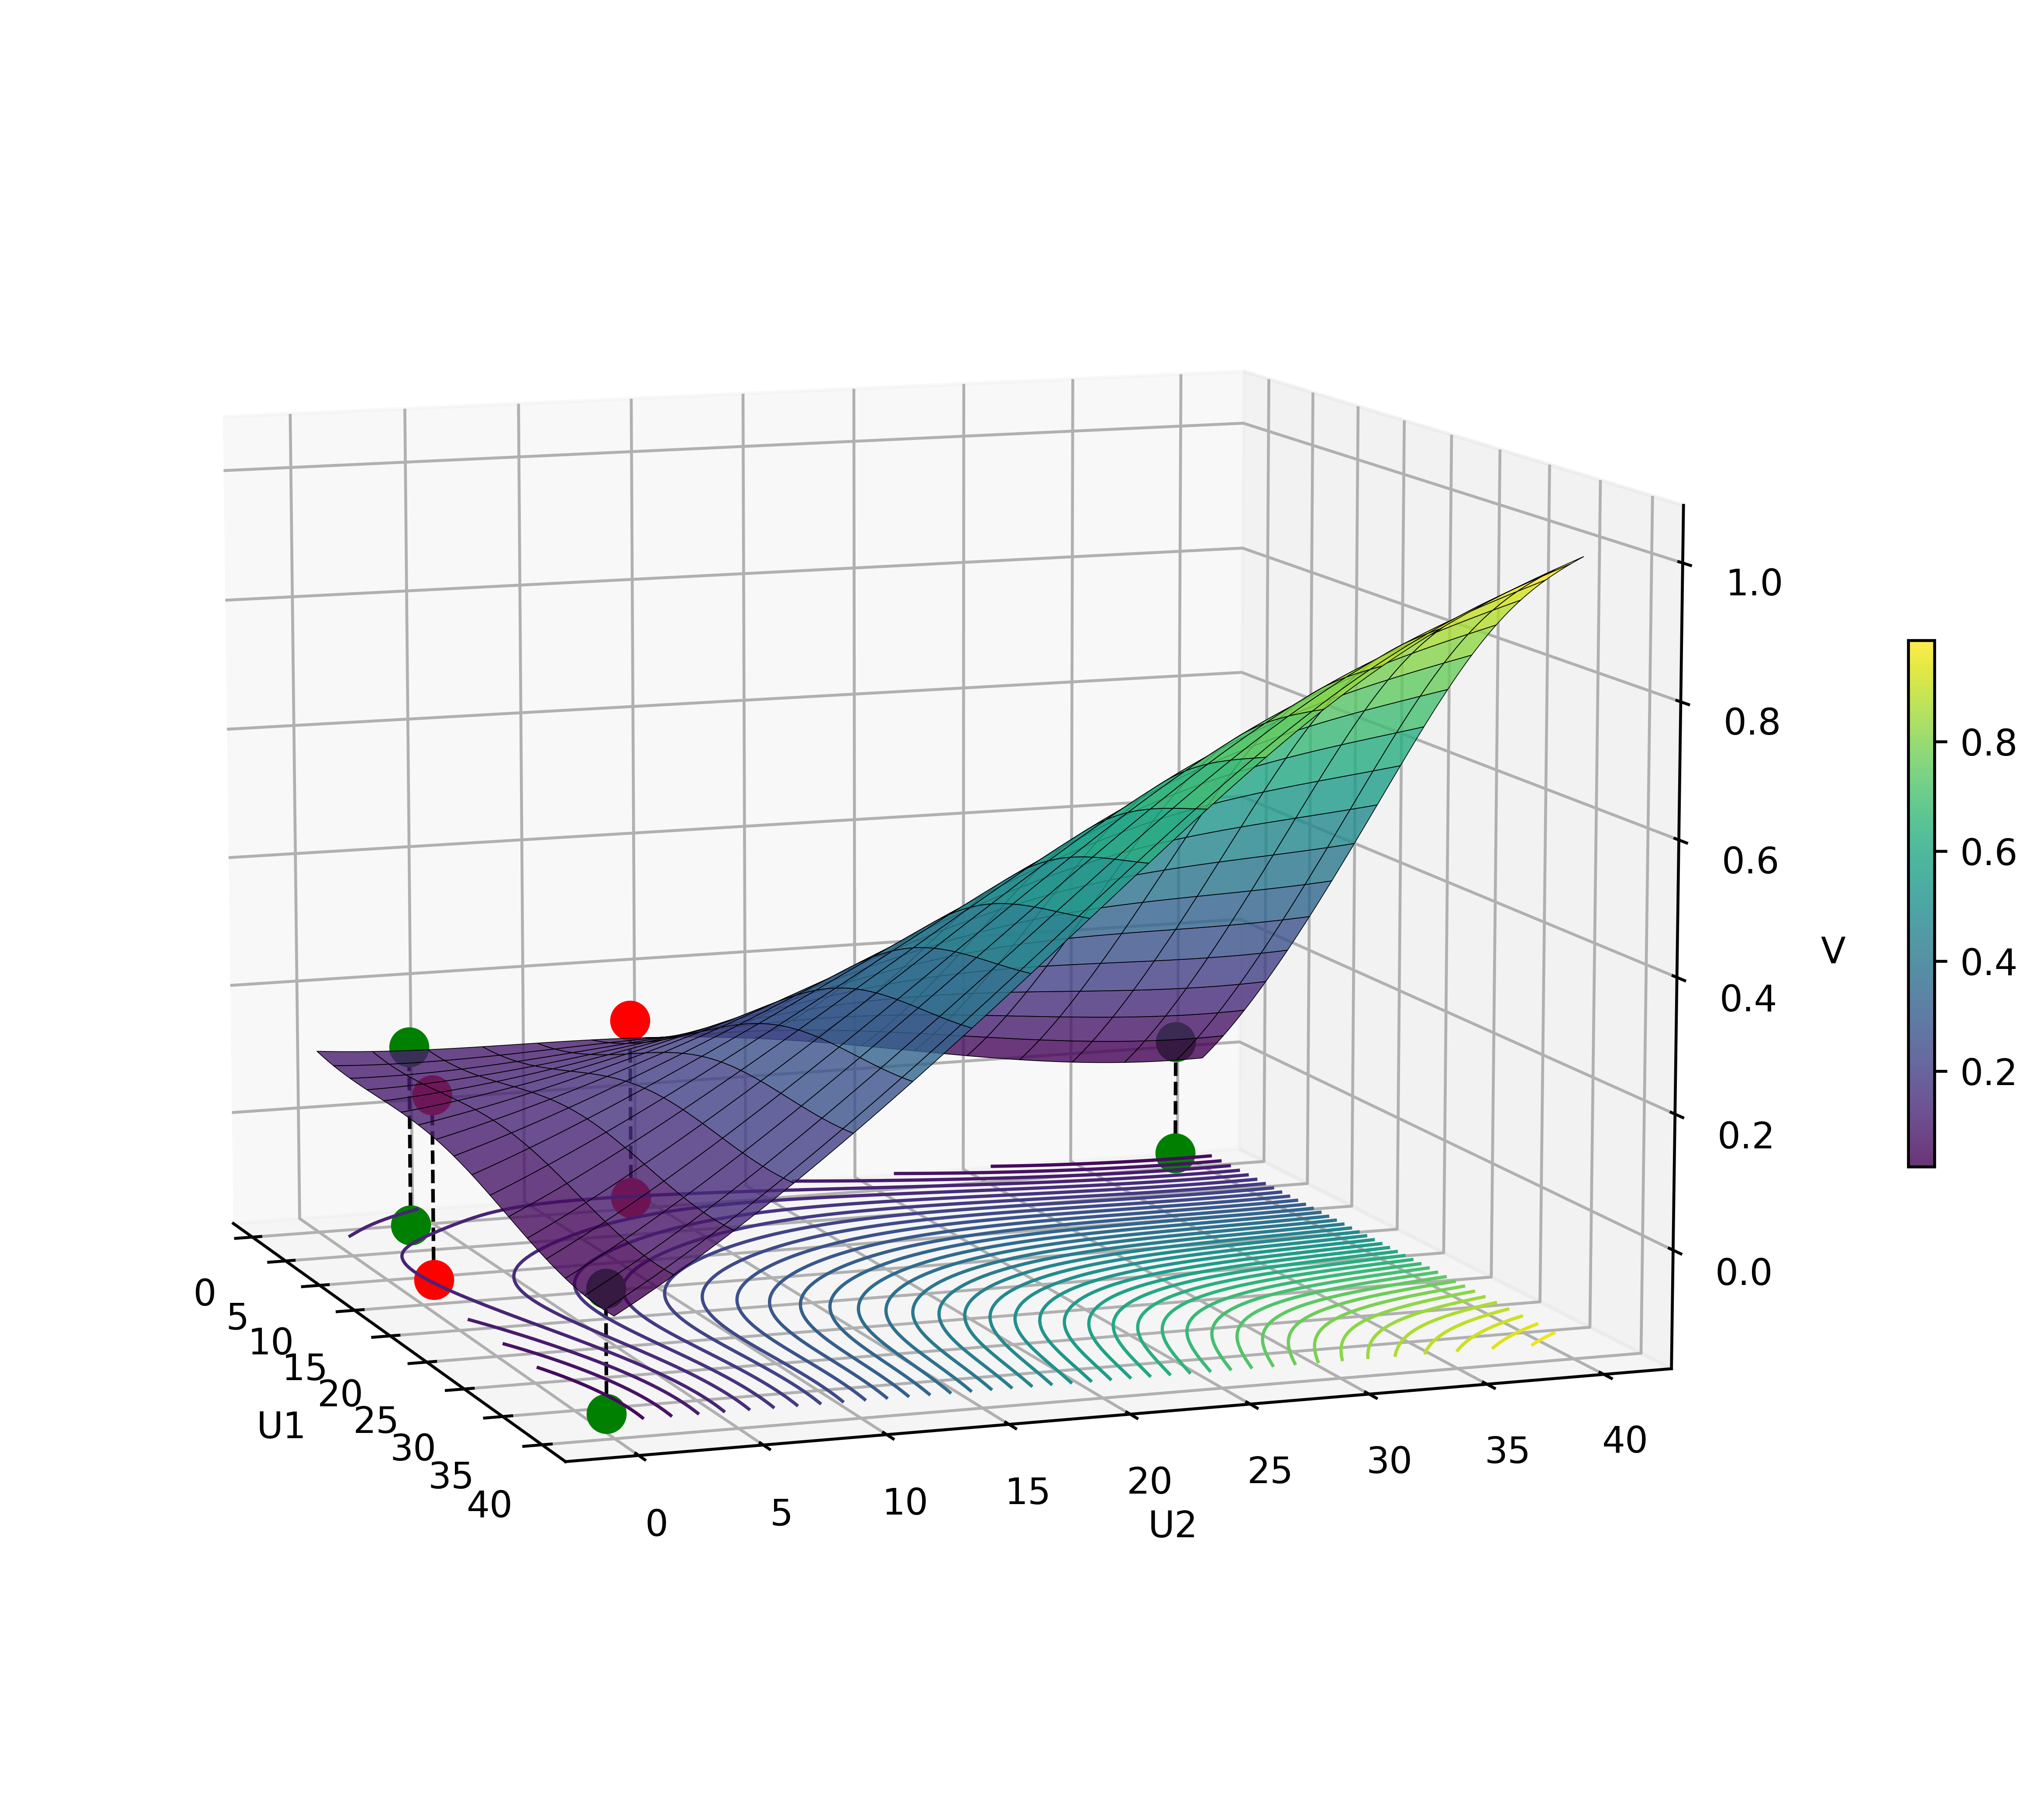

In [9]:
# Plot the potential
plot_potential_surface(U1_mesh, U2_mesh, V, fixed_points)